#With Histogram Equalization 

s2_validation

In [ ]:
import torch as th
import torchvision.transforms as T
import requests
from PIL import Image, ImageDraw, ImageFont, ImageOps
import numpy as np
import cv2

In [ ]:
# Load the pre-trained DETR model and move it to the GPU
model = th.hub.load('facebookresearch/detr', 'detr_resnet101', pretrained=True)
model.eval()
model = model.cuda()

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main


In [ ]:
# Define the input image transformation pipeline
transform = T.Compose([
    T.ToTensor(), # Convert the image to a PyTorch tensor
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalize the tensor with mean and standard deviation values
])

# Define the list of classes for object detection
CLASSES = ['building']

In [ ]:
len(CLASSES)

1

In [ ]:
url = "/content/ROIs0000_validation_s2_0_p8.jpg"

Processing low quality image: <PIL.Image.Image image mode=RGB size=800x1333 at 0x7FBD0B93BD30>


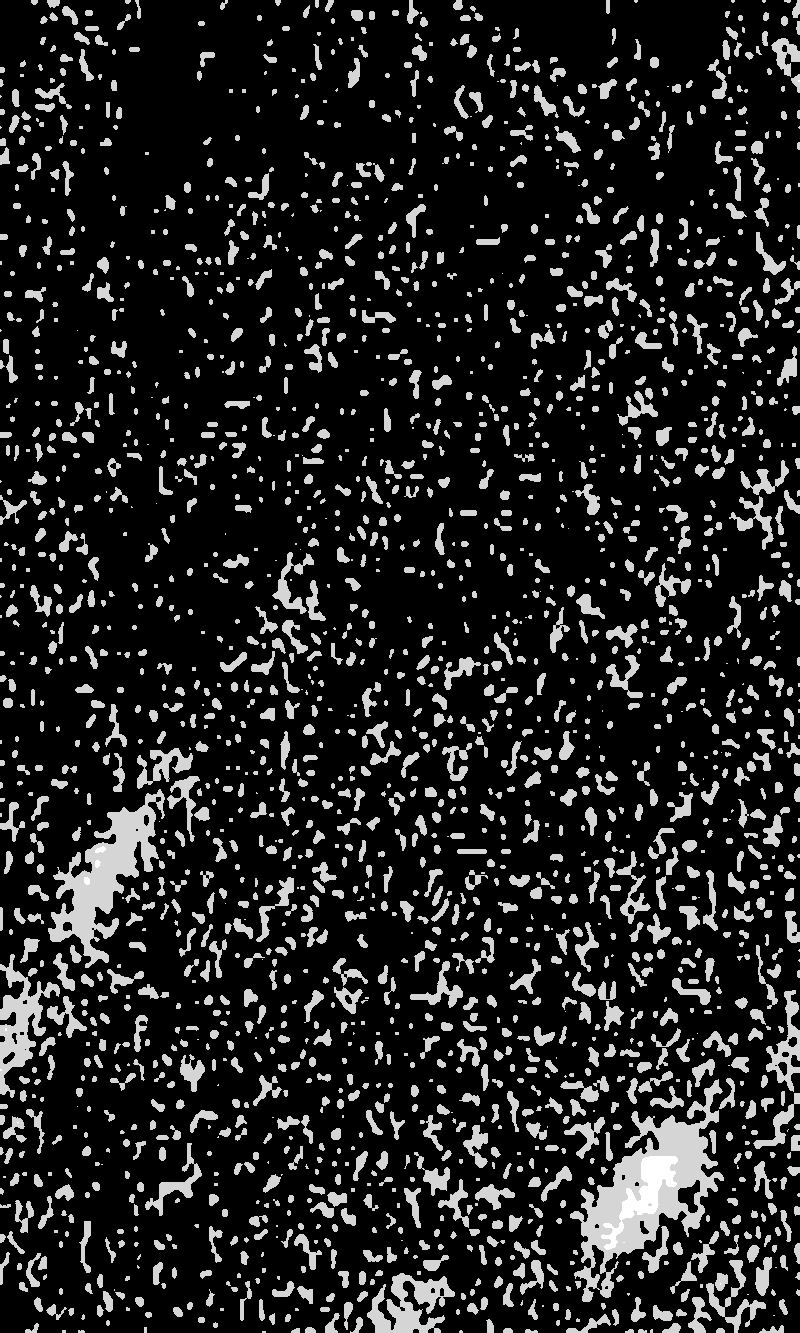

In [ ]:
# img = Image.open(requests.get(url, stream=True).raw).resize((800,1333)).convert('RGB')
img = Image.open(url).resize((800,1333)).convert('RGB')
# Check if the image is low quality
if np.mean(img) < 10 or np.mean(img) > 245:
    print(f"Processing low quality image: {img}")
    # Apply bilateral filtering to remove noise
    img_array = np.array(img)
    filtered = cv2.bilateralFilter(img_array, 9, 75, 75)
    img = Image.fromarray(filtered)
# apply histogram equalization
img = ImageOps.equalize(img)
img

In [ ]:
# Transform the image using the defined pipeline and move it to the GPU
img_tens = transform(img).unsqueeze(0).cuda()


In [ ]:
# Use the DETR model to generate predictions for the input image
with th.no_grad():
  output = model(img_tens)

In [ ]:
# Create a copy of the input image for drawing bounding boxes and labels
im2 = img.copy()

# Create a drawing context for the output image
drw = ImageDraw.Draw(im2)

# Get the predicted logits and boxes from the DETR output
pred_logits=output['pred_logits'][0][:, :len(CLASSES)]
pred_boxes=output['pred_boxes'][0]

# Find the predicted objects with the highest confidence scores
max_output = pred_logits.softmax(-1).max(-1)
topk = max_output.values.topk(15)

# Select the predicted logits and boxes for the top predicted objects
pred_logits = pred_logits[topk.indices]
pred_boxes = pred_boxes[topk.indices]
pred_logits.shape

torch.Size([15, 1])

In [ ]:
max_output

torch.return_types.max(
values=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0'))

In [ ]:
topk

torch.return_types.topk(
values=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0'),
indices=tensor([ 7,  6,  4,  5,  1,  0,  2,  3, 11, 10,  8,  9, 13, 12, 14],
       device='cuda:0'))

In [ ]:
pred_boxes

tensor([[0.5299, 0.6143, 0.0473, 0.0267],
        [0.6196, 0.6300, 0.0828, 0.0353],
        [0.8248, 0.8989, 0.0651, 0.0374],
        [0.5888, 0.9170, 0.0685, 0.0433],
        [0.5350, 0.8221, 0.0440, 0.0273],
        [0.3349, 0.7290, 0.0520, 0.0262],
        [0.3448, 0.6372, 0.0471, 0.0266],
        [0.8185, 0.8909, 0.0726, 0.0402],
        [0.8157, 0.8968, 0.0727, 0.0405],
        [0.4719, 0.6248, 0.0448, 0.0257],
        [0.4516, 0.9222, 0.0585, 0.0350],
        [0.1559, 0.6463, 0.0303, 0.0262],
        [0.4627, 0.5440, 0.0525, 0.0286],
        [0.2830, 0.7126, 0.0561, 0.0319],
        [0.6209, 0.9041, 0.0538, 0.0363]], device='cuda:0')

In [ ]:
pred_boxes.shape

torch.Size([15, 4])

In [ ]:
pred_logits

tensor([[-18.4073],
        [-18.4480],
        [-16.8147],
        [-16.9949],
        [-17.2602],
        [-17.8952],
        [-18.3954],
        [-16.6240],
        [-16.7171],
        [-18.2871],
        [-16.6297],
        [-18.3877],
        [-18.3640],
        [-18.5400],
        [-16.6451]], device='cuda:0')

In [ ]:
# Loop over the selected logits and boxes and draw bounding boxes and labels for each one
for logits, box in zip(pred_logits, pred_boxes):
  cls = logits.argmax()
  if cls >= len(CLASSES):
    continue
  label = CLASSES[cls]
  # Rescale the box coordinates to match the size of the original image
  box = box.cpu() * th.Tensor([800, 1333, 800, 1333])
  x, y, w, h = box
  x0, x1 = x-w//2, x+w//2
  y0, y1 = y-h//2, y+h//2
  # Draw a red rectangle around the object
  drw.rectangle([x0, y0, x1, y1], outline='red', width=5)
  # Add the class label to the image
  drw.text((x, y), label, fill='white')

In [ ]:
box

tensor([ 496.7565, 1205.1415,   43.0754,   48.4393])

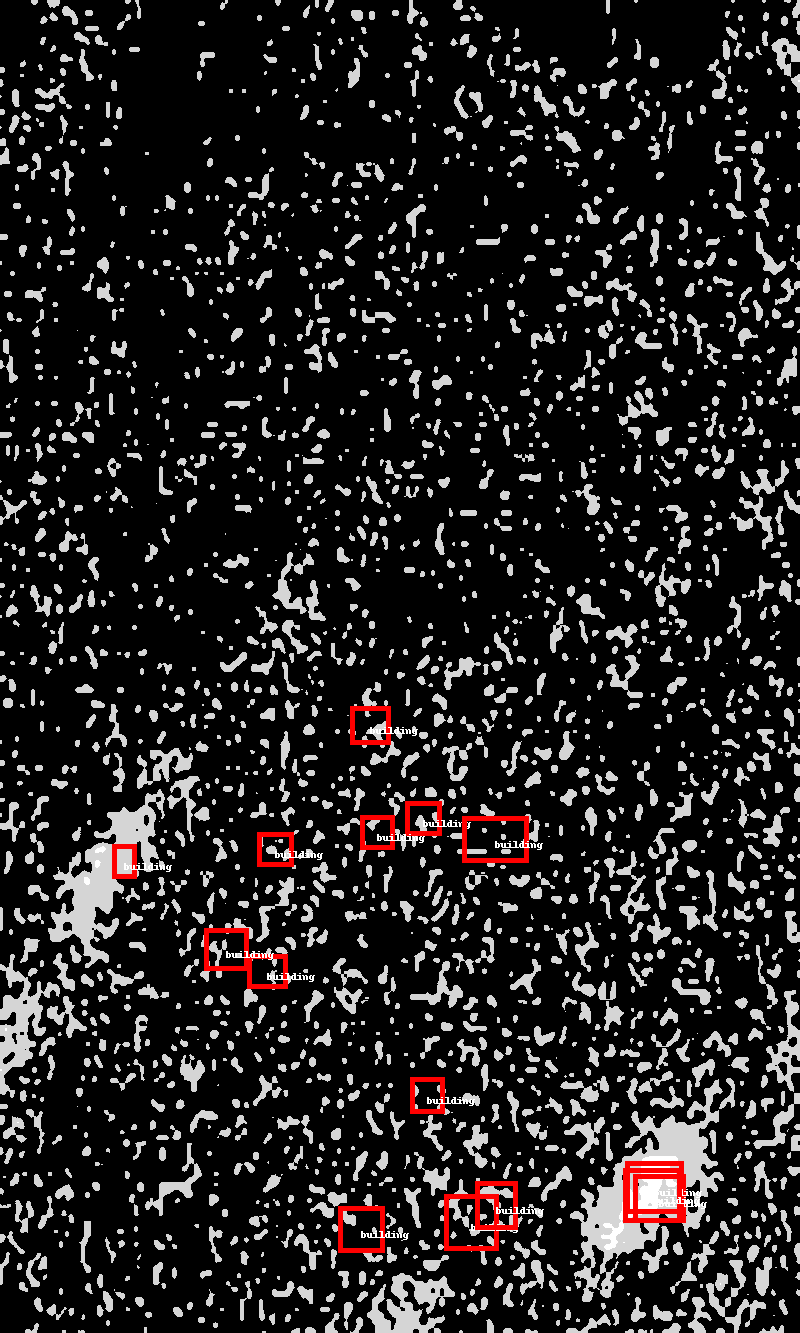

In [ ]:
im2

s2_0 

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main


Processing low quality image: <PIL.Image.Image image mode=RGB size=800x1333 at 0x7FBD0F950F70>


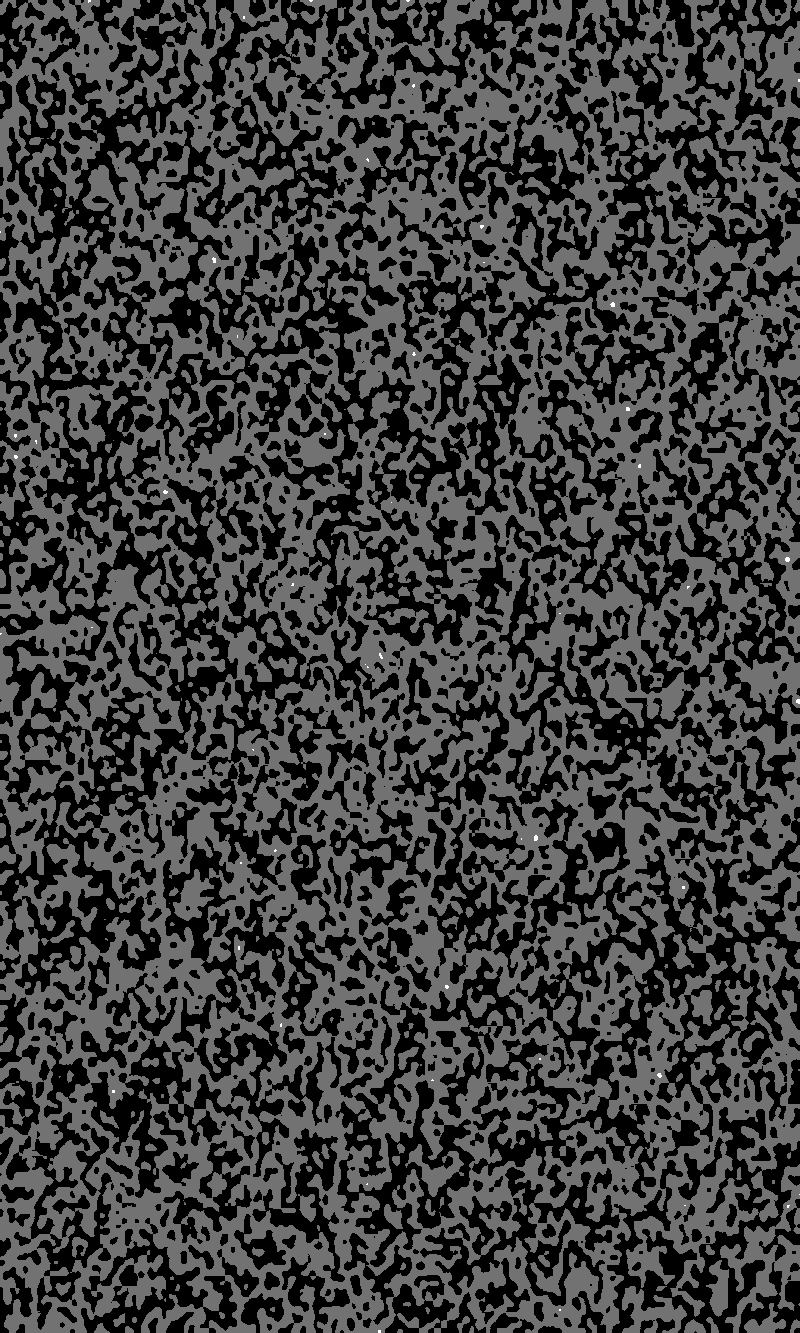

In [ ]:
model = th.hub.load('facebookresearch/detr', 'detr_resnet101', pretrained=True)
model.eval()
model = model.cuda()

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

CLASSES = ['building']

url = "/content/ROIs0000_test_s2_0_p8.jpg"
img = Image.open(url).resize((800,1333)).convert('RGB')
if np.mean(img) < 10 or np.mean(img) > 245:
    print(f"Processing low quality image: {img}")
        
    # Apply bilateral filtering to remove noise
    img_array = np.array(img)
    filtered = cv2.bilateralFilter(img_array, 9, 75, 75)
    img = Image.fromarray(filtered)
img = ImageOps.equalize(img)
img

building
building
building
building
building
building
building
building
building
building
building
building
building
building
building


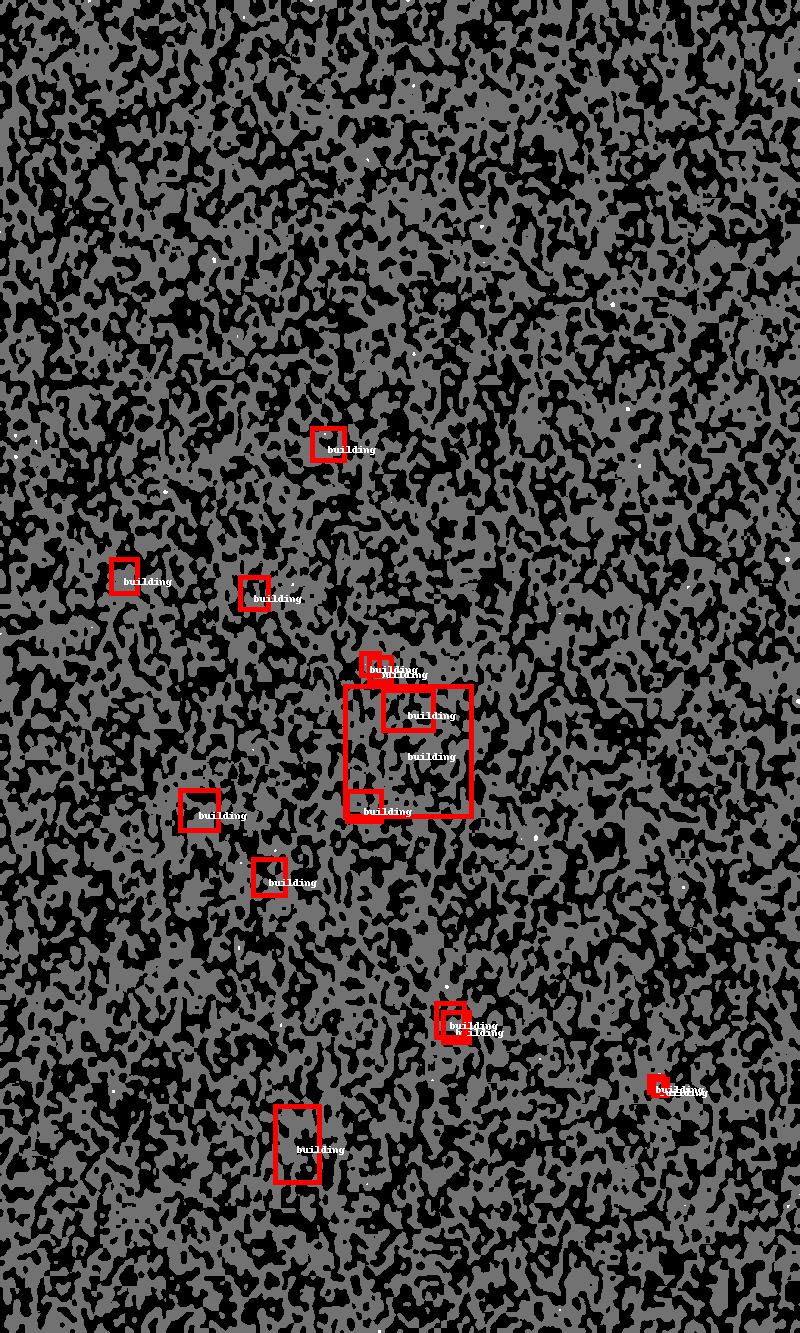

In [ ]:

img_tens = transform(img).unsqueeze(0).cuda()

with th.no_grad():
  output = model(img_tens)

im2 = img.copy()
drw = ImageDraw.Draw(im2)
pred_logits=output['pred_logits'][0][:, :len(CLASSES)]
pred_boxes=output['pred_boxes'][0]

max_output = pred_logits.softmax(-1).max(-1)
topk = max_output.values.topk(15)

pred_logits = pred_logits[topk.indices]
pred_boxes = pred_boxes[topk.indices]
pred_logits.shape

for logits, box in zip(pred_logits, pred_boxes):
  cls = logits.argmax()
  if cls >= len(CLASSES):
    continue
  label = CLASSES[cls]
  print(label)
  box = box.cpu() * th.Tensor([800, 1333, 800, 1333])
  x, y, w, h = box
  x0, x1 = x-w//2, x+w//2
  y0, y1 = y-h//2, y+h//2
  drw.rectangle([x0, y0, x1, y1], outline='red', width=5)
  drw.text((x, y), label, fill='white')
im2

#Without Histogram Equalization

s2_validation

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main


Processing low quality image: <PIL.Image.Image image mode=RGB size=800x1333 at 0x7FBD0F9C4FA0>
building
building
building
building
building
building
building
building
building
building
building
building
building
building
building


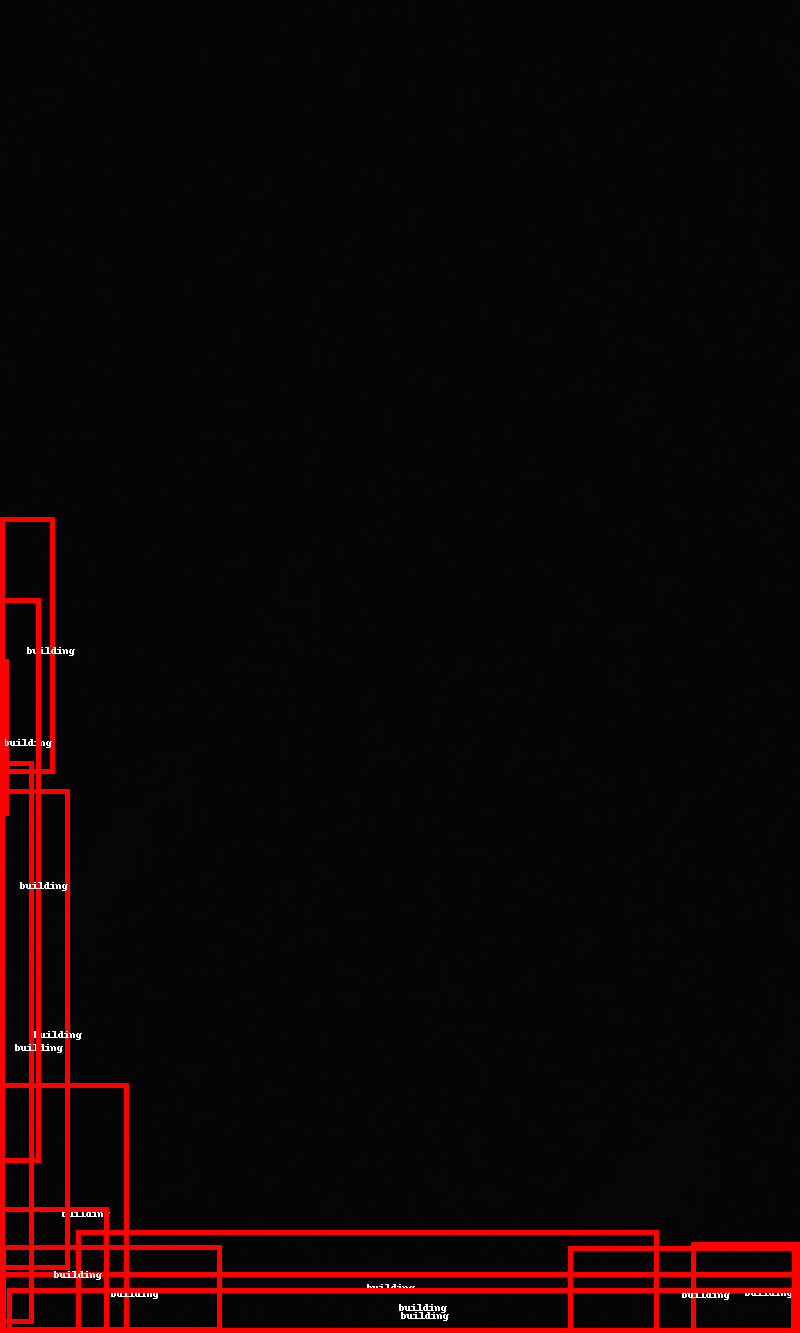

In [ ]:
model = th.hub.load('facebookresearch/detr', 'detr_resnet101', pretrained=True)
model.eval()
model = model.cuda()

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

CLASSES = ['building']

url = "/content/ROIs0000_validation_s2_0_p8.jpg"
img = Image.open(url).resize((800,1333)).convert('RGB')
if np.mean(img) < 10 or np.mean(img) > 245:
    print(f"Processing low quality image: {img}")
        
    # Apply bilateral filtering to remove noise
    img_array = np.array(img)
    filtered = cv2.bilateralFilter(img_array, 9, 75, 75)
    img = Image.fromarray(filtered)
    
img_tens = transform(img).unsqueeze(0).cuda()

with th.no_grad():
  output = model(img_tens)

im2 = img.copy()
drw = ImageDraw.Draw(im2)
pred_logits=output['pred_logits'][0][:, :len(CLASSES)]
pred_boxes=output['pred_boxes'][0]

max_output = pred_logits.softmax(-1).max(-1)
topk = max_output.values.topk(15)

pred_logits = pred_logits[topk.indices]
pred_boxes = pred_boxes[topk.indices]
pred_logits.shape

for logits, box in zip(pred_logits, pred_boxes):
  cls = logits.argmax()
  if cls >= len(CLASSES):
    continue
  label = CLASSES[cls]
  print(label)
  box = box.cpu() * th.Tensor([800, 1333, 800, 1333])
  x, y, w, h = box
  x0, x1 = x-w//2, x+w//2
  y0, y1 = y-h//2, y+h//2
  drw.rectangle([x0, y0, x1, y1], outline='red', width=5)
  drw.text((x, y), label, fill='white')
im2

s2_0

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main


Processing low quality image: <PIL.Image.Image image mode=RGB size=800x1333 at 0x7FBD0E335310>
building
building
building
building
building
building
building
building
building
building
building
building
building
building
building


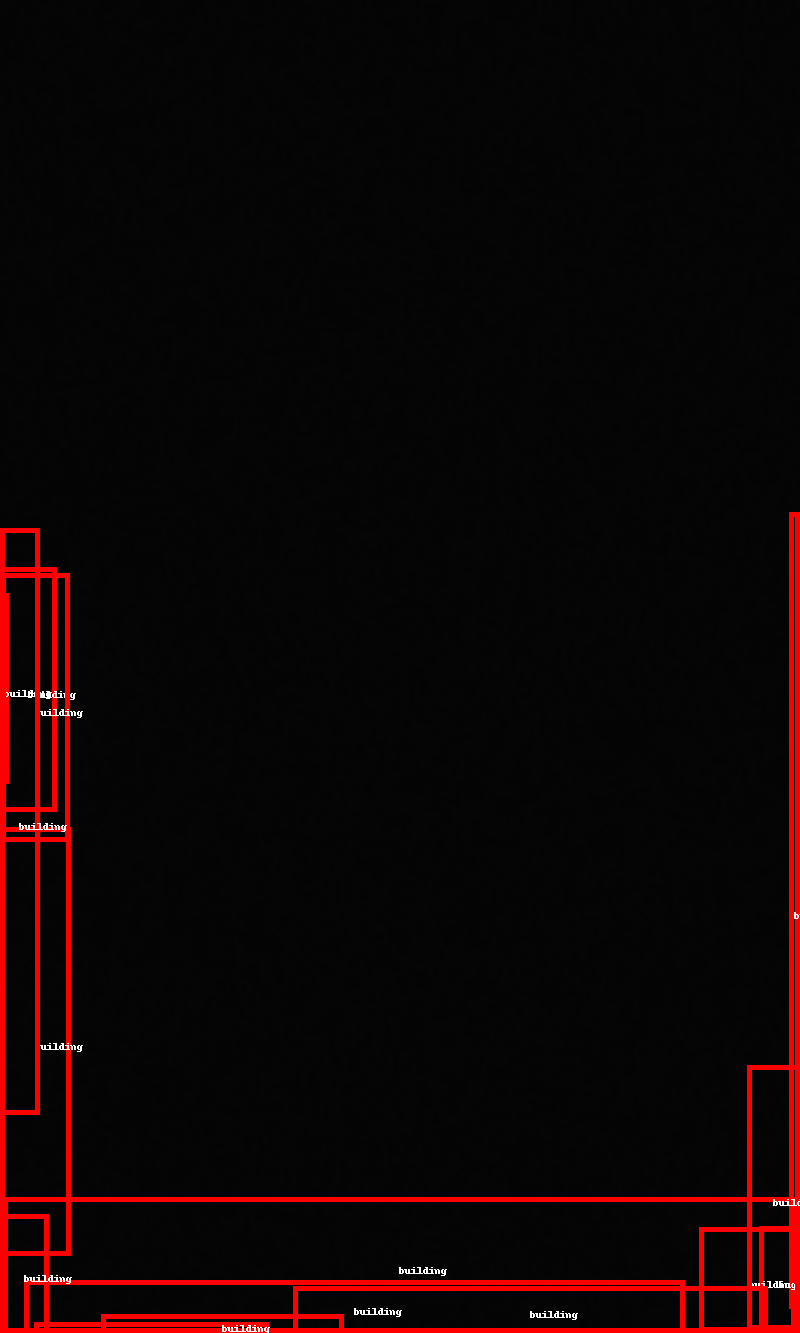

In [ ]:
model = th.hub.load('facebookresearch/detr', 'detr_resnet101', pretrained=True)
model.eval()
model = model.cuda()

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

CLASSES = ['building']

url = "/content/ROIs0000_test_s2_0_p8.jpg"
img = Image.open(url).resize((800,1333)).convert('RGB')
if np.mean(img) < 10 or np.mean(img) > 245:
    print(f"Processing low quality image: {img}")
        
    # Apply bilateral filtering to remove noise
    img_array = np.array(img)
    filtered = cv2.bilateralFilter(img_array, 9, 75, 75)
    img = Image.fromarray(filtered)
img_tens = transform(img).unsqueeze(0).cuda()

with th.no_grad():
  output = model(img_tens)

im2 = img.copy()
drw = ImageDraw.Draw(im2)
pred_logits=output['pred_logits'][0][:, :len(CLASSES)]
pred_boxes=output['pred_boxes'][0]

max_output = pred_logits.softmax(-1).max(-1)
topk = max_output.values.topk(15)

pred_logits = pred_logits[topk.indices]
pred_boxes = pred_boxes[topk.indices]
pred_logits.shape

for logits, box in zip(pred_logits, pred_boxes):
  cls = logits.argmax()
  if cls >= len(CLASSES):
    continue
  label = CLASSES[cls]
  print(label)
  box = box.cpu() * th.Tensor([800, 1333, 800, 1333])
  x, y, w, h = box
  x0, x1 = x-w//2, x+w//2
  y0, y1 = y-h//2, y+h//2
  drw.rectangle([x0, y0, x1, y1], outline='red', width=5)
  drw.text((x, y), label, fill='white')
im2